In [ ]:
import tensorflow as tf

#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input, Conv2D, add, Activation
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,AveragePooling2D,
                          GaussianNoise, UpSampling2D, Input)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt

import cv2
from imutils import paths
import numpy as np
import os
import time
import warnings
warnings.filterwarnings("ignore")
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.5.0


In [ ]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/Covid-CT-Scan", output="/content/drive/MyDrive/Covid-CT-Scan-80-20",  ratio=(.8, .2), group_prefix=None) # default values

In [ ]:
import requests
import tensorflow as tf

import tensorflow.keras.utils as np_utils


train_dir = '/content/drive/MyDrive/Covid-CT-Scan-80-20/train'
test_dir = '/content/drive/MyDrive/Covid-CT-Scan-80-20/val'

image_size = 224
H=image_size
W= image_size
batch_size = 32


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(H, W),
                                              batch_size=32,
                                              class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(H, W),
                                            batch_size=32,
                                            class_mode="categorical")

Found 1984 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [ ]:
model = Sequential(name="covid-ct-scan")
model.add(Conv2D(8,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal", input_shape=(H,W,3)))

model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size = (2,2), strides=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(16,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal"))

model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size = (2,2), strides=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Conv2D(32,(3,3),activation = "relu", padding ="same",kernel_initializer="he_normal"))

model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size = (2,2), strides=2))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation = "relu",padding ="same",kernel_initializer="he_normal"))

model.add(BatchNormalization())

model.add(AveragePooling2D(pool_size = (2,2), strides=2))
model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2,activation="softmax"))

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 798kB 11.1MB/s 


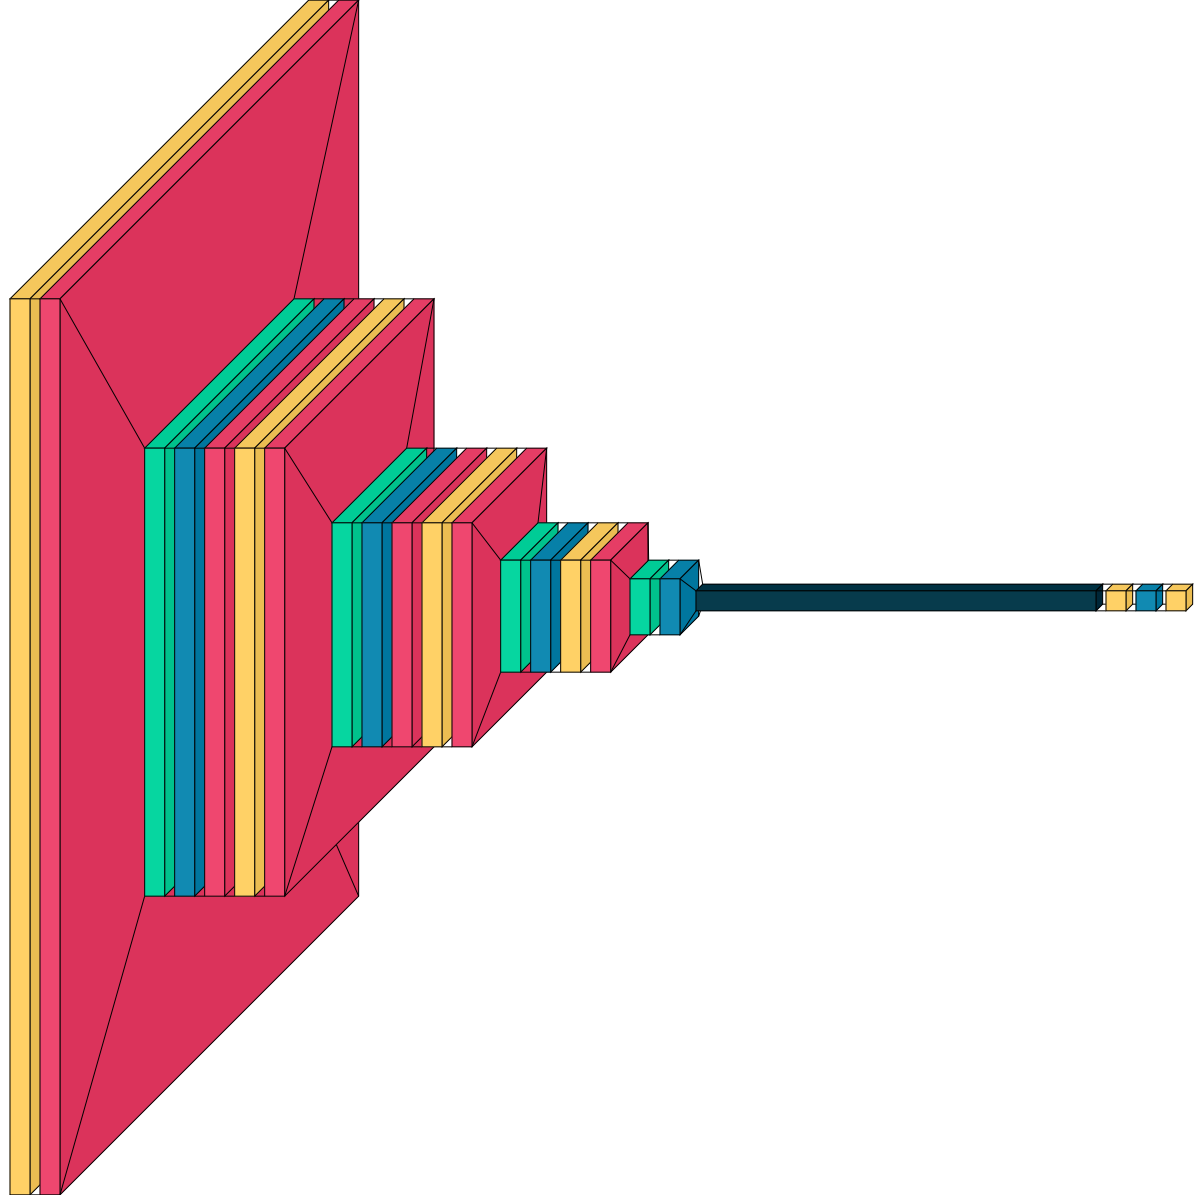

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "covid-ct-scan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
batch_normalization_12 (Batc (None, 224, 224, 8)       32        
_________________________________________________________________
average_pooling2d_8 (Average (None, 112, 112, 8)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 112, 112, 8)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 112, 8)       32        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
batch_normalization_14 (Batc (None, 112, 112, 16)    

In [ ]:
'''opt = RMSprop(learning_rate = 0.0001, rho = 0.99, epsilon = 1e-08, decay = 0.0)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy", "AUC"])

reduction_lr = ReduceLROnPlateau(monitor = "val_accuracy",patience = 2 ,verbose = 1, factor = 0.3, min_lr = 0.0000001)
reduction_lr1 = ReduceLROnPlateau(monitor = "val_loss",patience = 2 ,verbose = 1, factor = 0.3, min_lr = 0.0000001)
#bot_callback = botCallback(access_token)
#plotter = Plotter(access_token)
#callback_list = [bot_callback,plotter] callbacks=callback_list

start = time.time()'''

In [ ]:
model.compile(optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])

In [ ]:
from keras.callbacks import Callback
class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True
callbacks = [TerminateOnBaseline(monitor='val_accuracy', baseline=1)]

In [ ]:
history = model.fit_generator(train_data,
                    validation_data = test_data,
                    epochs=200,
                    callbacks=[TerminateOnBaseline(monitor='val_accuracy', baseline=0.9879)])

Epoch 1/200
62/62 [==============================] - 14s 221ms/step - loss: 0.0032 - accuracy: 0.9990 - auc: 1.0000 - val_loss: 0.1688 - val_accuracy: 0.9738 - val_auc: 0.9851
Epoch 2/200
62/62 [==============================] - 13s 216ms/step - loss: 0.0010 - accuracy: 0.9995 - auc: 1.0000 - val_loss: 0.1467 - val_accuracy: 0.9759 - val_auc: 0.9909
Epoch 3/200
62/62 [==============================] - 13s 217ms/step - loss: 3.5651e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.1489 - val_accuracy: 0.9779 - val_auc: 0.9873
Epoch 4/200
62/62 [==============================] - 13s 215ms/step - loss: 0.0035 - accuracy: 0.9985 - auc: 1.0000 - val_loss: 0.2499 - val_accuracy: 0.9598 - val_auc: 0.9818
Epoch 5/200
62/62 [==============================] - 14s 219ms/step - loss: 0.0010 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9718 - val_auc: 0.9868
Epoch 6/200
62/62 [==============================] - 14s 218ms/step - loss: 0.0026 - accuracy: 0.9990 - auc: 1.0000 

No handles with labels found to put in legend.


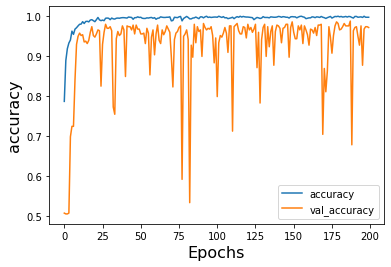

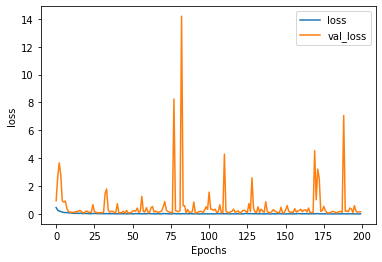

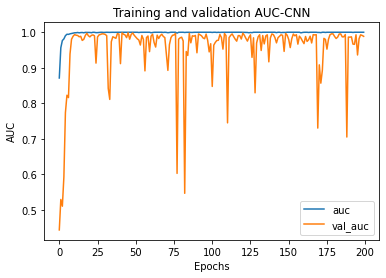

In [ ]:
def plot_graph(history,string):
    #plt.figure(figsize=(12,8))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label="val_"+str(string))
    plt.xlabel("Epochs")
    plt.ylabel(str(string))
    plt.legend()
    plt.show()

fig, ax = plt.subplots(figsize=(6, 4))

ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Intensity', fontsize=16)
leg = ax.legend(prop={"size":20})

plot_graph(history,"accuracy")
plot_graph(history,"loss")
plt.title('Training and validation AUC-CNN')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from flask import Flask, request, render_template
from werkzeug.utils import secure_filename

In [ ]:
model.save('/content/drive/MyDrive/h5-file/covid-ct-scan-Adam-98.79.h5')

In [ ]:
classes = {0:"COVID",1:"non-COVID"}

In [ ]:
prediction1=[]

In [ ]:
import os

directory = r'/content/drive/MyDrive/Covid-CT-Scan-80-20/val/non-COVID'
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
      image_path= os.path.join(directory, filename)
      image = load_img(image_path,target_size=(H,W))
      image = img_to_array(image)
      image = image/255
      image = np.expand_dims(image,axis=0)
      result = np.argmax(model.predict(image))
      prediction1.append(result)
        #print(os.path.join(directory, filename))
    else:
      continue

In [ ]:
actual=test_data.classes
predicted=prediction1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#actual 
# predicted values
#predicted  

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
'''tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[0,1,2,3]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)'''

# classification report for precision, recall f1-score and accuracy
matrix1 = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix1)

Confusion matrix : 
 [[249   2]
 [  4 242]]
Classification report : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       251
           1       0.99      0.98      0.99       246

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



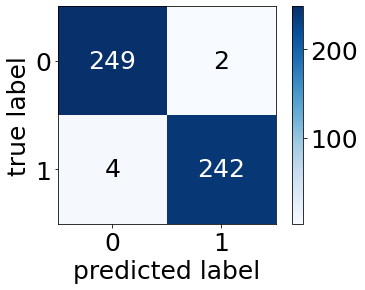

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams.update({'font.size': 25})
fig, ax = plot_confusion_matrix(conf_mat=matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False)
plt.show()


In [ ]:
import numpy as np
conf_mat = np.array(matrix)

def get_tpr_fnr_fpr_tnr(cm):
    dict_metric = dict()
    n = len(cm[0])
    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)
    array_sum = sum(sum(cm))
    #initialize a blank nested dictionary
    for i in range(1, n+1):
        keys = str(i)
        dict_metric[keys] = {"TPR":0, "FNR":0, "FPR":0, "TNR":0}
    # calculate and store class-wise TPR, FNR, FPR, TNR
    for i in range(n):
        for j in range(n):
            if i == j:
                keys = str(i+1)
                tp = cm[i, j]
                fn = row_sums[i] - cm[i, j]
                dict_metric[keys]["TPR"] = tp / (tp + fn)
                dict_metric[keys]["FNR"] = fn / (tp + fn)
                fp = col_sums[i] - cm[i, j]
                tn = array_sum - tp - fn - fp
                dict_metric[keys]["FPR"] = fp / (fp + tn)
                dict_metric[keys]["TNR"] = tn / (fp + tn)
    return dict_metric
import pandas as pd
df = pd.DataFrame(get_tpr_fnr_fpr_tnr(conf_mat)).transpose()
df

,TPR,FNR,FPR,TNR
1,0.992032,0.007968,0.016260,0.983740
2,0.983740,0.016260,0.007968,0.992032


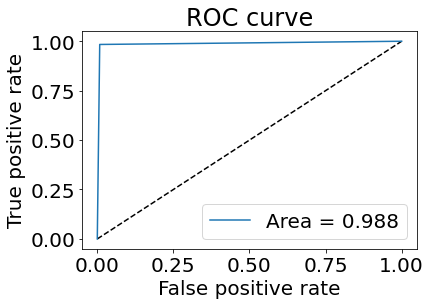

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
#y_pred_keras = model.predict_generator(test_data) #(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_data.classes, prediction1)
auc_keras = auc(fpr_keras, tpr_keras)
#ax = plt.axes()
#ax.set_facecolor("")

plt.figure(1)
plt.rcParams.update({'font.size': 20})
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig("/content/drive/MyDrive/h5-file/RMS-96.png", transparent=True)

In [ ]:
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/h5-file/covid-ct-scan-RMS-98.59-4.26MB.h5')

In [ ]:
img_path ='/content/drive/MyDrive/Covid-CT-Scan-80-20/val/COVID/Covid (1).png'
img = image.load_img(img_path, target_size=(H, W))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:5]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 224, 224, 8)


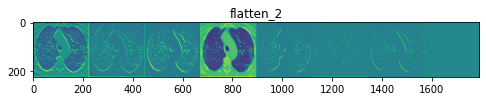

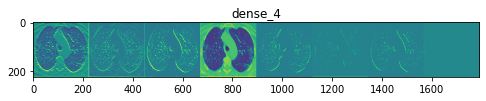

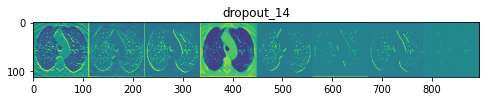

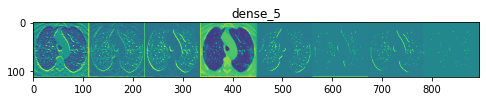

In [ ]:
layer_names = []
for layer in model.layers[18:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 8
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


313/313 - 1s - loss: 1.4708 - accuracy: 0.7042


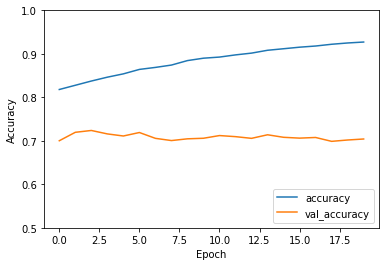

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)